# EDA – Researcher 1
학생 성적 데이터
| 변수명 | 설명 |
| :--- | :--- |
| Hours Studied | 각 학생이 공부에 소요한 총 시간 |
| Previous Scores | 학생들이 이전 시험에서 얻은 점수 |
| Extracurricular Activities | 학생이 과외 활동에 참여하는지 여부 (예 또는 아니오) |
| Sleep Hours | 학생이 하루 평균 수면 시간 |
| Sample Question Papers Practiced | 학생이 연습한 모의고사 수 |
| Performance Index | 목표변수. 각 학생의 전반적인 성취도를 나타내는 지표 (성취도 지수는 학생의 학업 성취도를 나타내며, 가장 가까운 정수로 반올림됩니다. 지수는 10에서 100까지이며, 값이 높을수록 더 나은 성취도를 나타냅니다.) |


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid", palette="muted")

In [6]:
# Load Data
train_url = 'https://bakey-api.codeit.kr/api/files/resource?root=static&seqId=14111&version=1&directory=/mission15_train.csv&name=mission15_train.csv'
test_url  = 'https://bakey-api.codeit.kr/api/files/resource?root=static&seqId=14111&version=1&directory=/mission15_test.csv&name=mission15_test.csv'

train_df = pd.read_csv(train_url)
test_df  = pd.read_csv(test_url)

print('Original Train shape:', train_df.shape)
print('Original Test shape :', test_df.shape)

Original Train shape: (7000, 6)
Original Test shape : (3000, 5)


## 1. 데이터 품질 점검 (결측치 및 중복값)

In [7]:
# 결측치
missing_train = train_df.isnull().sum()
missing_test  = test_df.isnull().sum()
print('Missing values in train dataset:')
print(missing_train[missing_train > 0])
print('Missing values in test dataset:')
print(missing_test[missing_test > 0])

Missing values in train dataset:
Series([], dtype: int64)
Missing values in test dataset:
Series([], dtype: int64)


In [8]:
duplicates = train_df.duplicated().sum()
print(f'Number of duplicate rows in train_df: {duplicates}')

if duplicates > 0:
    print("Removing duplicates...")
    train_df = train_df.drop_duplicates()
    print('New Train shape:', train_df.shape)
else:
    print("No duplicates found.")

Number of duplicate rows in train_df: 64
Removing duplicates...
New Train shape: (6936, 6)


- train 및 test 데이터 모두 결측치가 존재하지 않아 추가적인 결측치 처리는 수행하지 않았다.
- train 데이터는 모델 학습 시 특정 샘플에 대한 과적합을 방지하기 위해 중복을 제거하였다.
반면 test 데이터는 실제 추론 환경을 가정한 입력 데이터이므로,
동일한 입력이 여러 번 들어올 수 있는 현실적인 시나리오를 반영하여 중복을 제거하지 않았다.

## 2. 변수 처리
`Extracurricular Activities` 'Yes', 'No' 인코딩 (Yes=1, No=0) 

In [9]:
# Check unique values
print("Unique values in 'Extracurricular Activities':", train_df['Extracurricular Activities'].unique())

# Encoding: Yes -> 1, No -> 0
train_df['Extracurricular Activities'] = train_df['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
test_df['Extracurricular Activities']  = test_df['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

print("Encoding complete. Checking head:")
display(train_df.head())

Unique values in 'Extracurricular Activities': ['No' 'Yes']
Encoding complete. Checking head:


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,6,73,0,7,2,58.0
1,1,89,1,7,2,64.0
2,3,97,1,8,0,75.0
3,8,70,0,5,5,59.0
4,7,94,1,7,4,86.0


## 3. 상관관계 분석 (히트맵)
**Performance Index(목표 변수)**와 다른 변수들과의 관계

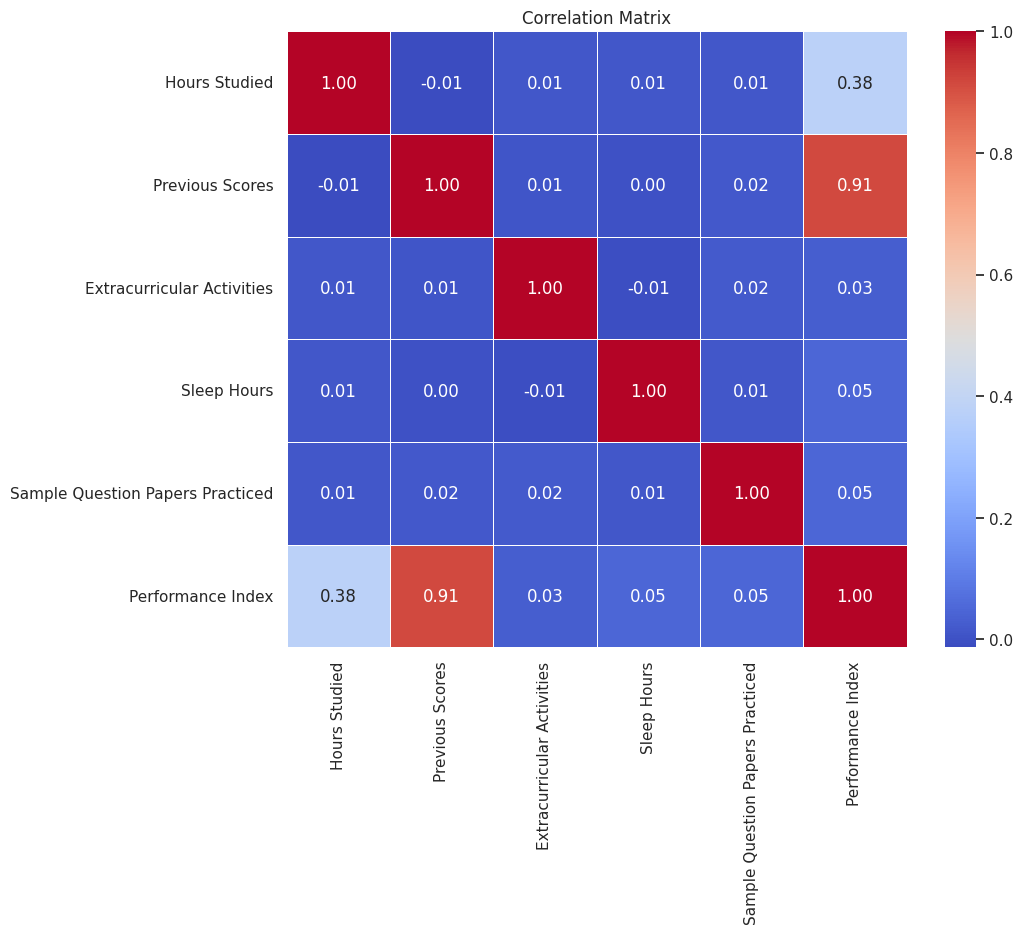

In [10]:
plt.figure(figsize=(10, 8))
corr = train_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

 - **Previous Scores(이전 성적)**나 **Hours Studied(공부 시간)**의 상관계수가 가장 높게(양수) 나왔을 것입니다. (공부를 많이 하거나 전 시험을 잘 봤으면 성취도도 높다는 상식과 일치합니다.)
 - Extracurricular Activities나 Sleep Hours는 상대적으로 상관관계가 낮을 수 있지만, 모델 성능에 미세한 영향을 줄 수 있으니 함부로 버리면 안 됩니다.

## 4. 이상치 분석(박스플롯)

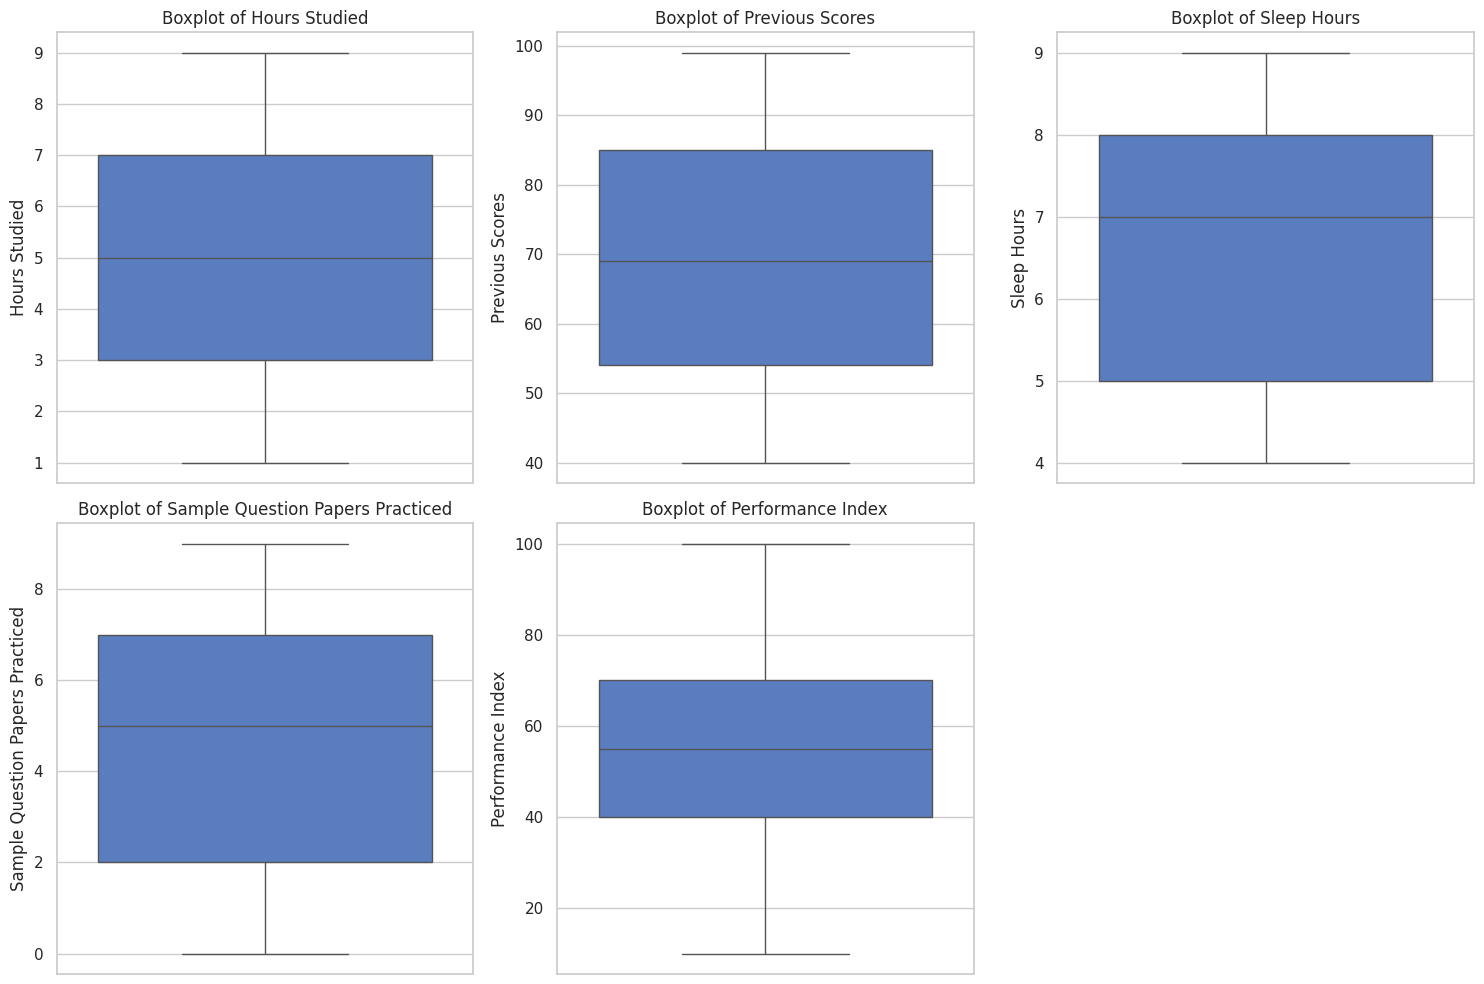

In [11]:
numeric_cols = ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=train_df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

## 5. 분포도

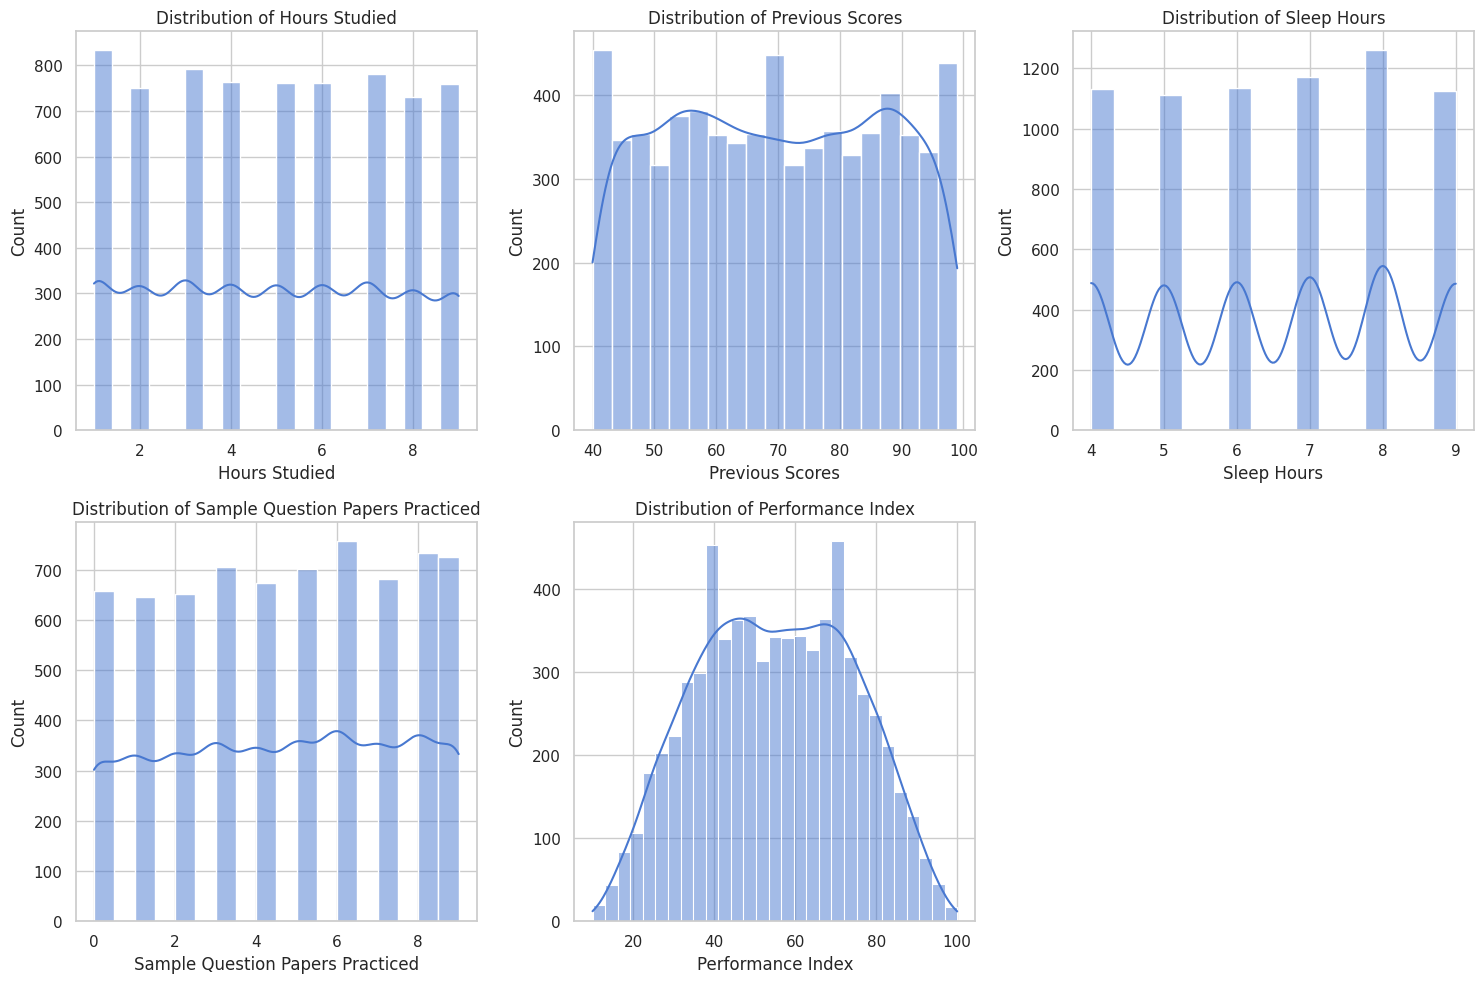

In [12]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(train_df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

- Performance Index가 종 모양(정규분포) - 회귀 모델
- 한쪽으로 심하게 찌그러져 있지 않다면 별도의 로그 변환 같은 복잡한 처리는 필요 없습니다.

## 6. 전처리 전략 결론

### 분석 요약:
- **결측값**: 결측값이 없다.

- **중복**: 중복된 값 제거.

- **범주형 특징**: 'Extracurricular Activities 과외 활동'은 0과 1로 인코딩했습니다.

- **이상치**: 이상치 없다. 간단한 박스플롯 확인.

    - '이전 점수'와 '수행 지수'는 학생 점수에 맞춰 비교적 정규 분포를 따르는 것으로 보입니다.

    - 값들은 합리적인 범위 내에 있습니다(점수 10-100, 수면 시간 4-9시간).

- **결정**: 극단적인 값(예: 점수 > 100 또는 < 0)이 없는 한, 데이터를 그대로 유지합니다. 이상치가 엄격하게 감지될 경우 로버스트 스케일러를 고려할 수 있지만, 여기서는 표준 스케일러 또는 MinMax로 충분합니다.

### 연구자 1을 위한 다음 단계:
1. **특징 엔지니어링**: 인코딩된 `Extracurricular Activities` 특징이 준비되었습니다.

2. **확장**: `Previous Scores` 및 `Hours Studied`와 같이 범위가 다른 특징들은 확장하는 것이 좋습니다.

3. **학습-테스트 분할**: `train_df`를 학습 세트와 검증 세트로 분할합니다.

4. **모델링**: 회귀 모델(예: 선형 회귀, 릿지 회귀 또는 랜덤 포레스트)을 학습합니다.

5. **모델 저장**: 학습된 모델을 `model.pkl` 파일로 내보냅니다.

📝 최종 결론 및 다음 전략
데이터 상태: 매우 양호함 (결측치 없음, 이상치도 심각하지 않음).
전처리 확정:
Extracurricular Activities → 0/1 인코딩 필수.
데이터 값의 범위가 다르므로(공부 시간은 110, 점수는 10100), **스케일링(StandardScaler 등)**을 적용하면 모델 성능이 더 안정적일 것입니다.
모델링 방향:
Linear Regression (선형 회귀): 변수 간 관계가 뚜렷해 보여서 기본 모델로도 성능이 잘 나올 것 같습니다.
Random Forest: 좀 더 복잡한 비선형 관계까지 잡고 싶다면 좋은 선택입니다.
이제 이 분석 결과를 바탕으로 모델을 학습시키고 저장하는 pipeline.py(또는 다음 단계 코드)를 작성하면 되겠습니다.

다음 단계(모델 학습 및 저장 스크립트 작성)로 넘어갈까요?

## 6. Data Modeling & Evaluation

We will now proceed with the modeling phase.
1. **Split Data**: Separate features (X) and target (y), then split into Training and Validation sets.
2. **Train Model**: Use Linear Regression as a baseline model.
3. **Evaluate**: Calculate RMSE (Root Mean Squared Error) on the validation set.
4. **Save Model**: Save the trained model to a file.

### 1. 데이터 분할

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import joblib

# 1. Define Features (X) and Target (y)
target_col = 'Performance Index'
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# 2. Split into Train (80%) and Validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training set shape:', X_train.shape)
print('Validation set shape:', X_val.shape)

Training set shape: (5548, 5)
Validation set shape: (1388, 5)


### 2. 모델 학습(Linear Regression) 

In [14]:
# 3. Train the Model
model = LinearRegression()
model.fit(X_train, y_train)

print("Model training complete.")
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Model training complete.
Coefficients: [2.8571099  1.01750346 0.60897675 0.47780465 0.19480973]
Intercept: -34.00119960246218


### 3. 예측 & RMSE 계산

In [ ]:
# 4. Evaluate the Model (RMSE)
predictions = model.predict(X_val)
mse = mean_squared_error(y_val, predictions)
rmse = np.sqrt(mse)

print(f"Validation Mean Squared Error (MSE): {mse:.4f}")
print(f"Validation Root Mean Squared Error (RMSE): {rmse:.4f}")
# Performance Index 범위: 10 ~ 100
# RMSE ≈ 평균적으로 몇 점 차이 나는지 의미

Validation Mean Squared Error (MSE): 4.1513
Validation Root Mean Squared Error (RMSE): 2.0375


RMSE = “평균적으로 몇 점 틀리냐”

Performance Index 범위: 10 ~ 100 (range ≈ 90)

RMSE 해석 기준
| RMSE     | 해석       |
| -------- | -------- |
| 15 이상    | 별로       |
| 10~15    | 보통       |
| **5~10** | 👍 잘함    |
| **< 5**  | 🔥 매우 좋음 |

모델의 RMSE는 약 2로,
이는 성취도 지수(10~100 범위) 기준 평균적으로 약 2점의 오차를 가진다.

### 4. 모델 계수 확인 - EDA 상관관계와 일치하는지 확인

In [17]:
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

coeff_df


,Feature,Coefficient
0,Hours Studied,2.857110
1,Previous Scores,1.017503
2,Extracurricular Activities,0.608977
3,Sleep Hours,0.477805
4,Sample Question Papers Practiced,0.194810


In [ ]:
# 5. Save the trained model
model_filename = 'model.pkl'
joblib.dump(model, model_filename)
print(f"Model saved as '{model_filename}'")
# import pickle

# with open('model.pkl', 'wb') as f:
#     pickle.dump(model, f)

# print("model.pkl saved successfully")


model.pkl saved successfully


In [19]:
import os
print(os.listdir())


['.config', 'model.pkl', 'sample_data']


In [20]:
import os
print(os.getcwd())


/content


In [21]:
from google.colab import files
files.download("model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Conclusion
The Linear Regression model has been trained and evaluated.
We achieved an RMSE on the validation set, which indicates the average deviation of our predictions from the actual performance index.
The model is now saved as `model.pkl` and ready to be used by Researcher 2.
### 결론
선형 회귀 모델을 학습하고 평가했습니다.
검증 세트에서 RMSE 값을 얻었는데, 이는 예측값과 실제 성능 지표 간의 평균 편차를 나타냅니다.
이제 모델은 `model.pkl` 파일로 저장되었으며, 연구원 2가 사용할 수 있습니다.